In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from data import load_ensembles

2024-10-15 16:00:06.902996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 16:00:06.932015: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

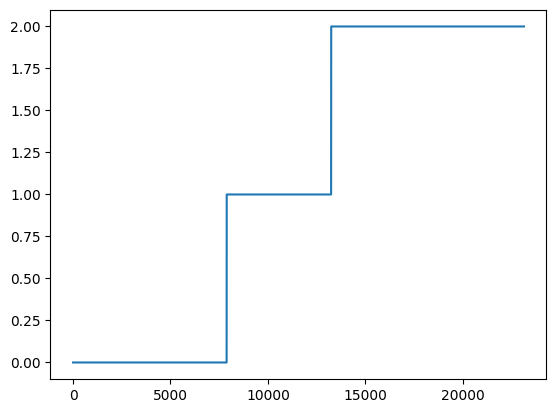

In [2]:
X, y_base = load_ensembles()
oh_enc = OneHotEncoder(sparse_output=False)
y = oh_enc.fit_transform(y_base)
plt.plot(y_base)
y

In [3]:
X_train_base, X_test_base, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print(X_train_base.shape)
print(X_test_base.shape)

abs_max = np.abs(X_train_base - 1).max()

X_train = (X_train_base - 1)/abs_max
X_test = (X_test_base - 1)/abs_max

# X_scaler = StandardScaler()
# X_train = X_scaler.fit_transform(X_train_base.reshape((-1, 1))).reshape(X_train_base.shape)
# X_test = X_scaler.transform(X_test_base.reshape((-1, 1))).reshape(X_test_base.shape)

(18512, 180, 100)
(4628, 180, 100)


In [11]:
x_input = keras.Input(X.shape[1:])
x = x_input
x = keras.layers.Conv1D(128, 5, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Conv1D(64, 5, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(x_input, x)

optimizer = keras.optimizers.RMSprop(5e-6)
model.compile(optimizer=optimizer, loss="bce")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 100)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 180, 128)          64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 90, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 90, 64)            41024     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 45, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2880)              0   

In [12]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
 56/492 [==>...........................] - ETA: 1s - loss: 0.6920

2024-09-23 20:25:58.390507: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


492/492 [==============================] - ETA: 0s - loss: 0.6847

2024-09-23 20:26:00.487736: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


492/492 [==============================] - 3s 5ms/step - loss: 0.6847 - val_loss: 0.6730
Epoch 2/100
492/492 [==============================] - 2s 4ms/step - loss: 0.6538 - val_loss: 0.6264
Epoch 3/100
492/492 [==============================] - 2s 5ms/step - loss: 0.5942 - val_loss: 0.5513
Epoch 4/100
492/492 [==============================] - 2s 4ms/step - loss: 0.5148 - val_loss: 0.4661
Epoch 5/100
492/492 [==============================] - 2s 5ms/step - loss: 0.4336 - val_loss: 0.3869
Epoch 6/100
492/492 [==============================] - 2s 4ms/step - loss: 0.3616 - val_loss: 0.3201
Epoch 7/100
492/492 [==============================] - 2s 4ms/step - loss: 0.3004 - val_loss: 0.2642
Epoch 8/100
492/492 [==============================] - 2s 4ms/step - loss: 0.2495 - val_loss: 0.2181
Epoch 9/100
492/492 [==============================] - 2s 5ms/step - loss: 0.2072 - val_loss: 0.1806
Epoch 10/100
492/492 [==============================] - 2s 4ms/step - loss: 0.1733 - val_loss: 0.1517
E

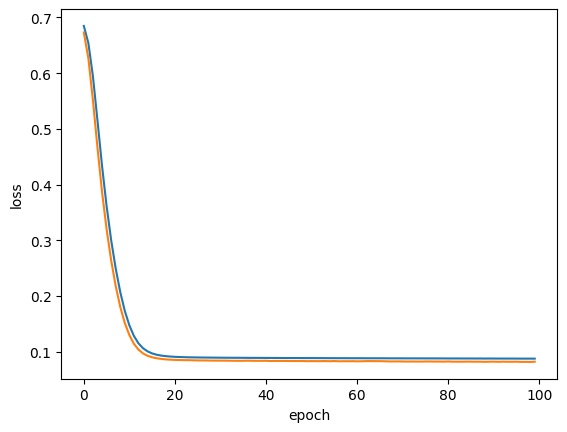

In [13]:
history_curve = history.history
history_curve["epoch"] = list(range(len(history_curve["loss"])))
fig, ax = plt.subplots()
sns.lineplot(history_curve, x="epoch", y="loss", ax=ax)
sns.lineplot(history_curve, x="epoch", y="val_loss", ax=ax)
plt.show()

145/145 [==============================] - 0s 1ms/step


[Text(0.5, 1.0, 'Test')]

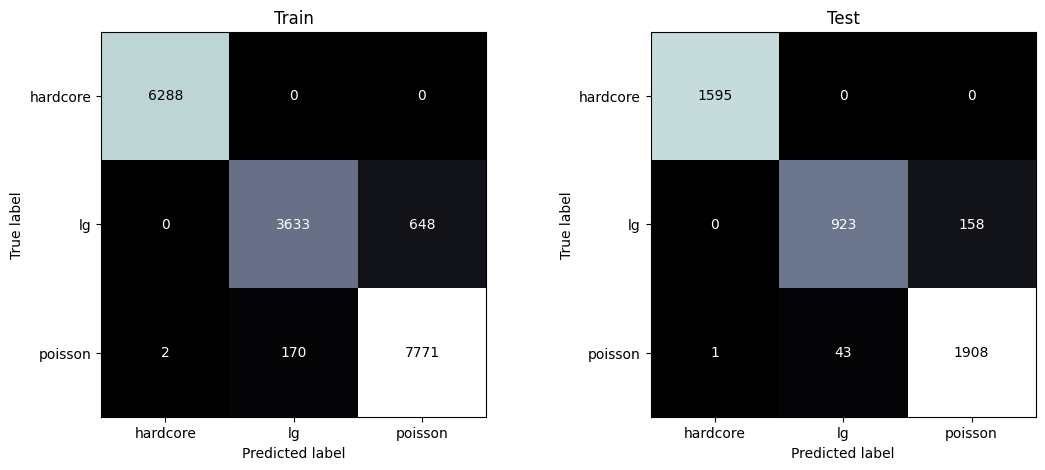

In [14]:
pred_train = model.predict(X_train)
y_train_disp = oh_enc.inverse_transform(y_train)
pred_train_disp = oh_enc.inverse_transform(pred_train)

pred_test = model.predict(X_test)
y_test_disp = oh_enc.inverse_transform(y_test)
pred_test_disp = oh_enc.inverse_transform(pred_test)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay.from_predictions(y_train_disp, pred_train_disp, ax=ax[0], colorbar=False, cmap="bone", display_labels=["hardcore", "lg", "poisson"])
ax[0].set(title="Train")
ConfusionMatrixDisplay.from_predictions(y_test_disp, pred_test_disp, ax=ax[1], colorbar=False, cmap="bone", display_labels=["hardcore", "lg", "poisson"])
ax[1].set(title="Test")